In [39]:
import shutil
from pathlib import Path

import cv2
import numpy as np
import typer
from pycocotools.coco import COCO
from rich.console import Console
from rich.progress import track
import matplotlib.pyplot as plt
from PIL import Image
from segmentation_mask_overlay import overlay_masks

INPUT_DIR = Path("/opt/ml/input")
DATA_ROOT = INPUT_DIR / "data"
CLASSES = [
    "Backgroud",
    "General trash",
    "Paper",
    "Paper pack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic bag",
    "Battery",
    "Clothing",
]
COLORS = [
    (0, 0, 0),
    (128, 224, 128),
    (128, 62, 62),
    (30, 142, 30),
    (192, 0, 0),
    (50, 50, 160),
    (0, 224, 224),
    (0, 0, 224),
    (192, 224, 0),
    (192, 224, 224),
    (192, 96, 0),
    (0, 224, 0),
]

In [4]:
def imshow(image: np.ndarray):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [5]:
coco_file = 'val.json'  # train.json / val.json / test.json
coco_json_path = DATA_ROOT / coco_file
coco_directory = coco_json_path.parent

coco = COCO(coco_json_path)

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [6]:
category_ids = coco.getCatIds()
print(f"category_ids = {category_ids!r}")

categories = coco.loadCats(category_ids)
print("categories = ")
categories

category_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
categories = 


[{'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

### Set image index

In [25]:
index = 0

In [26]:
img_info = coco.imgs[index]
img_info

{'license': 0,
 'url': None,
 'file_name': 'batch_01_vt/0002.jpg',
 'height': 512,
 'width': 512,
 'date_captured': None,
 'id': 0}

In [27]:
img_path = coco_directory / img_info["file_name"]
img_path

PosixPath('/opt/ml/input/data/batch_01_vt/0002.jpg')

### Show original image

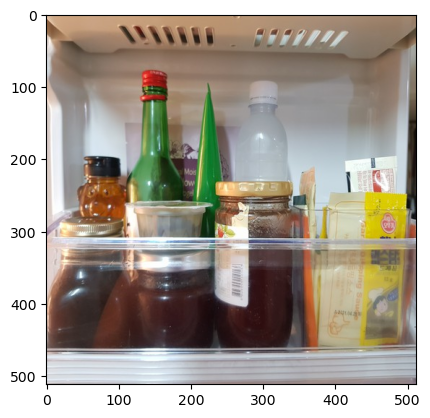

In [28]:
image = cv2.imread(str(img_path))
imshow(image)

In [29]:
img_id = img_info['id']

ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)
print(f"ann_ids = {ann_ids!r}")
print(f"len(anns) = {len(anns)!r}")
print(f"ann category id = {[ann['category_id'] for ann in anns]}")


ann_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
len(anns) = 17
ann category id = [8, 8, 6, 5, 5, 6, 5, 6, 6, 8, 8, 8, 8, 8, 8, 8, 5]


### Show binary mask and color mask

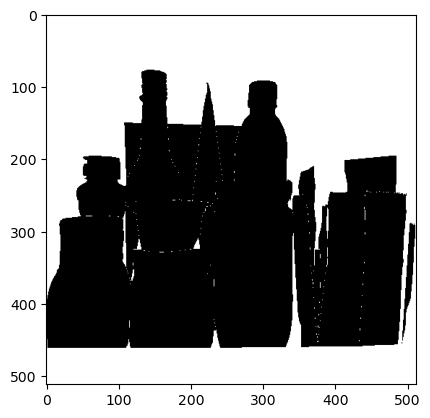

In [30]:
mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)
color_mask = np.zeros((img_info["height"], img_info["width"], 3), dtype=np.uint8)

for ann in anns:
    class_index = ann["category_id"]
    mask[coco.annToMask(ann) == 1] = class_index
    color_mask[coco.annToMask(ann) == 1] = COLORS[class_index]

ret, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV)
imshow(binary_mask)

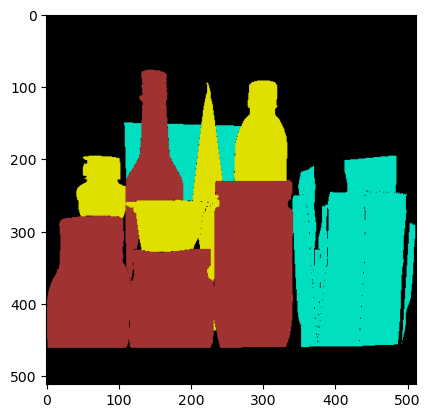

In [31]:
imshow(color_mask)

### Show labels

Text(0.5, 0.98, '/opt/ml/input/data/batch_01_vt/0002.jpg')

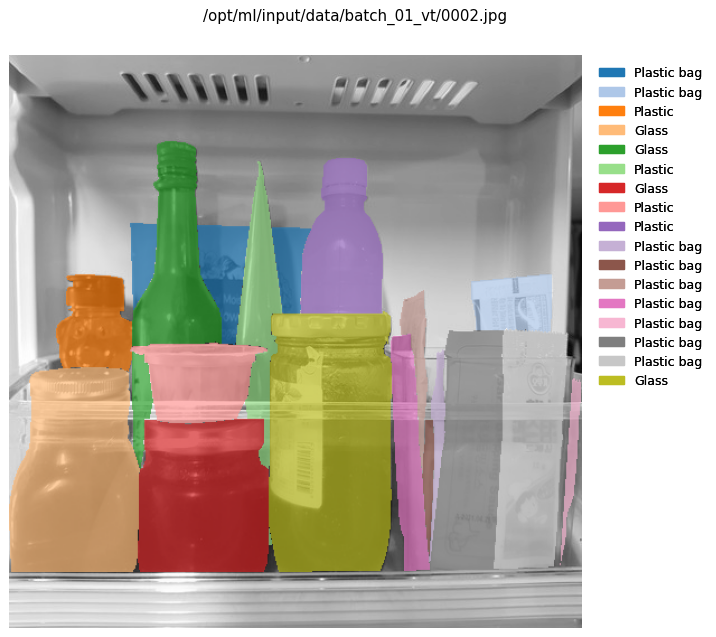

In [55]:
image2 = Image.open(img_path).convert("L")
image2 = np.array(image2)

masks, mask_labels = [], []
for ann in anns:
    class_index = ann["category_id"]
    mask = np.zeros(image2.shape, dtype="bool")
    mask[coco.annToMask(ann) == 1] = class_index
    masks.append(mask)
    mask_labels.append(CLASSES[class_index])

cmap = plt.cm.tab20(np.arange(len(mask_labels)))

fig = overlay_masks(image2, masks, labels=mask_labels, colors=cmap, mask_alpha=0.7)

fig.suptitle(str(img_path))

# fig.savefig("cat_masked.png", bbox_inches="tight", dpi=300)